In [40]:
import pyfits
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn as skl
import sklearn.neighbors.kde as kde
from astropy.io import fits
from astropy.cosmology import FlatLambdaCDM
import pyfits as pf
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
%pylab inline
import copy
pd.set_option('display.max_columns', None)
%pylab inline
#import seaborn as sns
#sns.set()

Populating the interactive namespace from numpy and matplotlib
Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [20]:
true_hdulist = pyfits.open('../../Buzzard_v1.1_truth.147.fit')

In [21]:
# list of all variables
true_hdulist[1].header

XTENSION= 'BINTABLE'           /Binary table written by MWRFITS v1.11           
BITPIX  =                    8 /Required value                                  
NAXIS   =                    2 /Required value                                  
NAXIS1  =                  330 /Number of bytes per row                         
NAXIS2  =              5022692 /Number of rows                                  
PCOUNT  =                    0 /Normally 0 (no varying arrays)                  
GCOUNT  =                    1 /Required value                                  
TFIELDS =                   48 /Number of columns in table                      
COMMENT                                                                         
COMMENT  *** End of mandatory fields ***                                        
COMMENT                                                                         
COMMENT                                                                         
COMMENT  *** Column names **

In [22]:
true_data = tru_hdulist[1].data

In [23]:
FILTER = np.where(tru_data['Z']<2.)[0]

In [ ]:
indice

In [10]:
#info from the kcorrect.pro documentation:

#Outputs:

#   mass          - [ngals] model mass derived from the coeffs (current
#                   surviving stellar mass)
#   intsfh        - [ngals] total integrated star-formation history (number of
#                   stars formed total)
#   mets          - [ngals] average metallicity of currently surviving stars
#   mtol          - [nk, ngals] model mass-to-light in each *final*
#                   bandpass (the bandpass you are kcorrecting *to*)
#                   in SOLAR UNITS!
#   b300          - star-formation within last 300Myrs relative to
#                   average star-formation rate
#   b1000         - star-formation within last 1Gyrs relative to
#                   average star-formation rate




#   For v4_0b templates and later, coefficients are in units of: 
# 
#     1 solar mass / (D/10pc)^2 
#
#   That is, sum the coefficients and multiply by (D/10pc)^2 to get
#   TOTAL INTEGRATED STAR FORMATION. (In fact, for Omega0=0.3 and
#   OmegaL0=0.7, this is what the "mass" keyword returns). Note that
#   the total integrated star formation DIFFERS from the current
#   stellar mass --- which is returned in the mass and mtol variables.

In [24]:
directory='../'
tspecfile=directory+'k_nmf_derived.default.fits'
t=fits.open(tspecfile)
#read in coefficients for each template
tbdata=t[18].data
tmass=t[16].data
tmremain=t[17].data
tmetallicity=t[18].data
tmass300=t[19].data
tmass1000=t[20].data
cosmology=FlatLambdaCDM(H0=70, Om0=0.286)

In [25]:
obs_hdulist = pyfits.open('../../Buzzard_v1.1.147.fit')

In [31]:
obs_hdulist[1].header

XTENSION= 'BINTABLE'           /Binary table written by MWRFITS v1.11           
BITPIX  =                    8 /Required value                                  
NAXIS   =                    2 /Required value                                  
NAXIS1  =                  144 /Number of bytes per row                         
NAXIS2  =              5022692 /Number of rows                                  
PCOUNT  =                    0 /Normally 0 (no varying arrays)                  
GCOUNT  =                    1 /Required value                                  
TFIELDS =                   35 /Number of columns in table                      
COMMENT                                                                         
COMMENT  *** End of mandatory fields ***                                        
COMMENT                                                                         
COMMENT                                                                         
COMMENT  *** Column names **

In [32]:
true_hdulist[1].header

XTENSION= 'BINTABLE'           /Binary table written by MWRFITS v1.11           
BITPIX  =                    8 /Required value                                  
NAXIS   =                    2 /Required value                                  
NAXIS1  =                  330 /Number of bytes per row                         
NAXIS2  =              5022692 /Number of rows                                  
PCOUNT  =                    0 /Normally 0 (no varying arrays)                  
GCOUNT  =                    1 /Required value                                  
TFIELDS =                   48 /Number of columns in table                      
COMMENT                                                                         
COMMENT  *** End of mandatory fields ***                                        
COMMENT                                                                         
COMMENT                                                                         
COMMENT  *** Column names **

In [15]:
#initialize arrays
b300=np.zeros(nredshifts)
b1000=np.zeros(nredshifts)
tmp_mass=np.zeros(nredshifts)
mets=np.zeros(nredshifts)
mass=np.zeros(nredshifts)
intsfh=np.zeros(nredshifts)

# do all the calculations, looping over objects
for i in np.arange(nredshifts):
    b300[i]=np.sum(tmass300*coeffs[:,i])/np.sum(tmass*coeffs[:,i])
    b1000[i]=np.sum(tmass1000*coeffs[:,i])/np.sum(tmass*coeffs[:,i])
    tmp_mass[i]=np.sum(tmremain*coeffs[:,i])
    mets[i]=np.sum(tmremain*tmetallicity*coeffs[:,i])/tmp_mass[i]
    dmod=cosmology.distmod(redshift[i])
    mass[i]=tmp_mass[i]*10.**(0.4*dmod.value)
    intsfh[i]=np.sum(coeffs[:,i])*10.**(0.4*dmod.value)

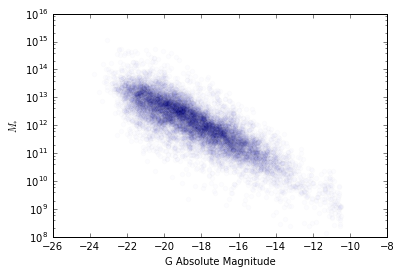

In [16]:
#stellar mass vs abs mag, seek schechter function
plt.scatter(tru_data['AMAG'][tru_ind][:,1],mass,alpha=0.01)
plt.semilogy()
plt.ylabel(r'$M_{*}$')
plt.xlabel('G Absolute Magnitude')

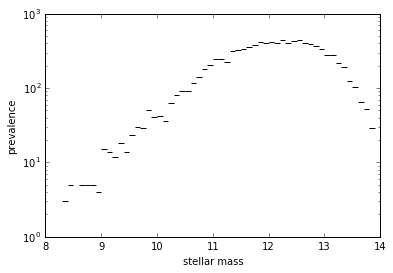

In [17]:
#seek schechter function
bins = np.arange(8,14,0.1)
plt.hist(np.log10(mass),bins=bins)
plt.semilogy()
plt.xlabel('stellar mass')
plt.ylabel('prevalence')

In [19]:
obs_hdulist.info()

Filename: Buzzard_v1.1.147.fit
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU       4   ()              
1                BinTableHDU     87   5022692R x 35C   [K, J, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E]   


In [20]:
obs_hdulist[1].header

XTENSION= 'BINTABLE'           /Binary table written by MWRFITS v1.11           
BITPIX  =                    8 /Required value                                  
NAXIS   =                    2 /Required value                                  
NAXIS1  =                  144 /Number of bytes per row                         
NAXIS2  =              5022692 /Number of rows                                  
PCOUNT  =                    0 /Normally 0 (no varying arrays)                  
GCOUNT  =                    1 /Required value                                  
TFIELDS =                   35 /Number of columns in table                      
COMMENT                                                                         
COMMENT  *** End of mandatory fields ***                                        
COMMENT                                                                         
COMMENT                                                                         
COMMENT  *** Column names **

In [ ]:
#Downsampling and filtering observaions:
N = 100000
indinces = np.random.choice(range(0,len(100000)), obs_hdulist[1].data[0])
low_indices = np.where(tru_data['Z'] < 2.)
tru_ind = np.random.choice(lo_z_ind[0],n_tru)